## Import and Functions

In [1]:
import os
import gc
import sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, Conv2D, MaxPool1D, Dropout, Flatten
%matplotlib inline

2022-07-01 17:07:36.024730: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-01 17:07:36.027712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 17:07:36.027721: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def progress_bar(percent):
    bar_len = 20
    n = int(percent*bar_len)#int(percent*100//bar_len)
    p = int(percent*100//1)
    print("\r["+("="*n + " "*int(bar_len-n))+"] "+str(p)+"%",end=" ")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Random Seeds and Data Import

In [3]:
# Set a seed value: 
keras.utils.set_random_seed(5)

In [4]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"]
    train_x_data     = var["train_x_data"][:]
    train_y_data     = var["train_y_data"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    test_y_sorted    = var["test_y_sorted"][:]
    test_y_sorted_ed = var["test_y_sorted_ed"][:]
    freq             = var["freq"][:]

with open("data/synthetic_data", 'rb') as file:
    var = pickle.load(file)
    spectra = var["spectra"]
    params  = var["parameters"]
    tc = params["tc"]/115000
    fpe = np.array(params["fpe"])/50e3
    ne = params["ne"] 
    vsw = params["vsw"] 

## Building Model

In [5]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 8)             32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 8)             200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 8)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 88)                0         
                                                                 
 dense (Dense)               (None, 8)                 7

2022-07-01 17:07:39.715685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-01 17:07:39.715727: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 17:07:39.715755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-07-01 17:07:39.716203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Training algorithm

In [6]:
model.compile(loss = lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .0015), 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [39]:
step_num = 12800#int(len(train_y_data)//32)
history = model.fit(
    x=train_x_data[:], y=train_y_data[:], epochs=20, batch_size=32, steps_per_epoch=step_num,
    validation_split=.1, workers=4, use_multiprocessing=True, verbose=2, shuffle=True)

Epoch 1/20
12800/12800 - 13s - loss: 2.8702e-05 - mean_absolute_percentage_error: 4.2767 - val_loss: 1.4902e-05 - val_mean_absolute_percentage_error: 2.2393 - 13s/epoch - 1ms/step
Epoch 2/20
12800/12800 - 13s - loss: 1.3671e-05 - mean_absolute_percentage_error: 2.0995 - val_loss: 1.2203e-05 - val_mean_absolute_percentage_error: 1.8295 - 13s/epoch - 1ms/step
Epoch 3/20
12800/12800 - 12s - loss: 1.1075e-05 - mean_absolute_percentage_error: 1.7371 - val_loss: 1.1108e-05 - val_mean_absolute_percentage_error: 1.7396 - 12s/epoch - 965us/step
Epoch 4/20
12800/12800 - 13s - loss: 9.9257e-06 - mean_absolute_percentage_error: 1.5761 - val_loss: 9.2846e-06 - val_mean_absolute_percentage_error: 1.4623 - 13s/epoch - 996us/step
Epoch 5/20
12800/12800 - 13s - loss: 9.3209e-06 - mean_absolute_percentage_error: 1.4888 - val_loss: 1.2015e-05 - val_mean_absolute_percentage_error: 1.8079 - 13s/epoch - 994us/step
Epoch 6/20
12800/12800 - 13s - loss: 8.9591e-06 - mean_absolute_percentage_error: 1.4327 - val

In [73]:
len(np.array(spectra).repeat(20, axis=0))/32

320000.0

In [9]:
history = model.fit(
    x=np.array(spectra), y=np.array(fpe), epochs=2000, batch_size=16, steps_per_epoch=62,
    validation_split=0, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

Epoch 1/2000
62/62 - 0s - loss: 2.5682e-09 - mean_absolute_percentage_error: 377.7051 - 93ms/epoch - 2ms/step
Epoch 2/2000
62/62 - 0s - loss: 1.8781e-09 - mean_absolute_percentage_error: 313.8429 - 84ms/epoch - 1ms/step
Epoch 3/2000
62/62 - 0s - loss: 1.7478e-09 - mean_absolute_percentage_error: 293.3600 - 79ms/epoch - 1ms/step
Epoch 4/2000
62/62 - 0s - loss: 1.7634e-09 - mean_absolute_percentage_error: 274.4109 - 78ms/epoch - 1ms/step
Epoch 5/2000
62/62 - 0s - loss: 2.1456e-09 - mean_absolute_percentage_error: 346.6975 - 79ms/epoch - 1ms/step
Epoch 6/2000
62/62 - 0s - loss: 2.9339e-09 - mean_absolute_percentage_error: 406.9685 - 78ms/epoch - 1ms/step
Epoch 7/2000
62/62 - 0s - loss: 1.8825e-09 - mean_absolute_percentage_error: 299.0381 - 79ms/epoch - 1ms/step
Epoch 8/2000
62/62 - 0s - loss: 2.5164e-09 - mean_absolute_percentage_error: 389.7532 - 76ms/epoch - 1ms/step
Epoch 9/2000
62/62 - 0s - loss: 3.0175e-09 - mean_absolute_percentage_error: 428.0920 - 83ms/epoch - 1ms/step
Epoch 10/2

In [ ]:
model.save('ml_models/cnn_20220628synth.h5')

## Testing Model

In [46]:
model = load_model('ml_models/cnn_20220627.h5')

In [40]:
#print(type(spectra))
#perf = model.evaluate(np.array(spectra), np.array(fpe))
perf = model.evaluate(test_x_sorted, test_y_sorted)

1581/1581 [==============================] - 1s 692us/step - loss: 7.0583e-06 - mean_absolute_percentage_error: 1.1569


In [41]:
pred_y = model.predict(test_x_sorted)

1581/1581 [==============================] - 1s 604us/step


In [42]:
denorm_test = denorm(test_y_sorted, max_y)
denorm_pred = denorm(pred_y, max_y)[:,0]

In [43]:
constant = np.mean(list(map(lambda i: (denorm_test[i]**2)/test_y_sorted_ed[i],
               range(len(denorm_test)))))
pred_dens = list(map(lambda i: (denorm_pred[i]**2)/constant,
               range(len(denorm_pred))))
dens = list(map(lambda i: (denorm_test[i]**2)/constant,
               range(len(denorm_test))))

Each predicted value has an error of ±5.144270500625669e-05% or ±0.8822869822849326 kHz
The average predicted value is 25.270389556884766
Predicted first value: 14.665925979614258 ±0.8822869822849326 kHz
Each predicted electron density has an error of ±0.0008591800451034677 cm^-3


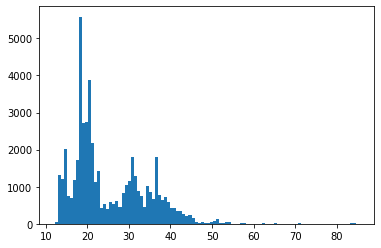

In [44]:
# Percent Error
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))
# Squared Error
lst2 = list(map(lambda i: (denorm_pred[i]-denorm_test[i])**2,
               range(len(pred_y))))
# Error
lst3 = list(map(lambda i: (denorm_pred[i]-denorm_test[i]),
               range(len(pred_y))))
# Electron Density Error
lst4 = list(map(lambda i: abs(pred_dens[i]-test_y_sorted_ed[i]),
               range(len(pred_y))))
error = np.sqrt(sum(lst2)/len(lst2))
print(f"Each predicted value has an error of ±{np.mean(lst)/np.sqrt(len(lst))}% or ±{error} kHz")
print(f"The average predicted value is {np.mean(denorm_pred)}")
print(f"Predicted first value: {denorm_pred[0]} ±{error} kHz")
print(f"Each predicted electron density has an error of ±{np.mean(lst4)/np.sqrt(len(lst4))} cm^-3")
plt.hist(denorm_test, bins=100)
plt.show()

In [35]:
pd.DataFrame(lst).describe()


,0
count,5.057300e+04
mean,8.159672e-03
std,1.808589e-02
min,1.587922e-07
25%,2.524463e-03
50%,5.040098e-03
75%,8.752207e-03
max,1.249458e+00


In [45]:
pd.DataFrame(lst).describe()


,0
count,50573.000000
mean,0.011569
std,0.036057
min,0.000000
25%,0.002449
50%,0.005476
75%,0.011138
max,2.220862


In [32]:
# try to figure out distribution of points
fr = np.array([0 for _ in range(85)])
for f in range(85):
    for _ in np.where(np.abs(train_y_data*50-(f+.5))<.5)[0]:
        fr[f] += 1
        

In [43]:
count = 0
for i in range(len(fr)):
    count += fr[i]
    if count>20000:
        print(i)#, fr[i], count)
        count = 0

[14,17,18, 19,20,21,23,27,29,31,34,36,39,45,60,80]

14
17
18
19
20
21
23
27
29
31
34
36
39
45


(14, 17, 18, 19, 20, 21, 31)

In [33]:
data_dic = {}
data_dic["Pred_y"] = denorm_pred
data_dic["Act_y"]  = denorm_test
data_dic["x"]      = test_x_sorted
data_dic["res"]    = lst3
with open("data/pickle/error_dist", 'wb') as file:
    pickle.dump(data_dic, file=file)

In [ ]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


## Ploting Figures

In [ ]:
plot_figs = True

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.title("Validation Performance after each epoch - MAPE")
    plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
    plt.axhline(perf[1], color='g', label="Average Error during Testing")
    plt.xlabel("Epoch (80% of total training data)")
    plt.ylabel("Average Percent Error (%)")
    plt.legend()
    plt.savefig("plots/validation_performance_over_time_mape.png", dpi=500)

In [ ]:
if plot_figs:
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN after trainning to match NASA's NN June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Neural Network(estimated)",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network - MAPE",linewidth=2)
    ax0.set_title("Predicted vs Estimated Plasma Frequency")
    ax0.set_xlabel("Epoch Time (s)")
    ax0.set_ylabel("Plasma Frequency (kHz)")
    ax0.legend()

    res = np.subtract(denorm(pred_y, max_y)[:,0],denorm(test_y_sorted, max_y))
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_NN")
    denorm_test = denorm(test_y_sorted, max_y)
    for i in range(len(res)):
        if denorm_test[i] < 10:
            ax1.scatter(test_time_sorted[i], res[i], s=3, color='r')

    ax1.set_title("Difference between CNN and NN")
    ax1.set_xlabel("Epoch Time (s)")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    fig.savefig("plots/performance_on_test_dataset_mape.png", dpi=500)

In [ ]:
if plot_figs:
    def norm_dist(val, mean=np.mean(lst3), standard_dev=np.std(lst3)):
        factor = 1/np.sqrt(2*np.pi*(standard_dev**2))
        exp = np.exp(-(val - mean)**2/(2*(standard_dev**2)))
        return factor*exp

    x = [-2 + i*.1 for i in range(40)]
    y = [norm_dist(v)*3000 for v in x]

In [ ]:
if plot_figs:
    fig, ax = plt.subplots(facecolor='w')
    ax.hist(lst3, 2000, histtype='bar')
    ax.set_xlim(-3,3)
    ax.set_title("Histogram of residual distribution - MAPE")
    ax.set_xlabel("Residual (kHz)")
    ax.set_ylabel("Number of Occurences")
    ax.plot(x,y)
    plt.savefig("plots/hist_mape.png", dpi=500)

In [ ]:
# Finding all outliers with a frequency error greater than 5
data_zip = list(filter(lambda x: abs(x[4])>10, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_outliers, test_x_sorted_outliers, test_y_sorted_outliers, pred_y_outliers, res_outliers = list(zip(*data_zip))

In [ ]:
# data_zip2 = list(filter(lambda x: abs(x[4])<.00003, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
# test_time_sorted_best, test_x_sorted_best, test_y_sorted_best, pred_y_best, res_best = list(zip(*data_zip2))

In [ ]:
if plot_figs:
    n = len(res_outliers)
    #plt.figure(figsize=(15, 4*n))
    fig, ax = plt.subplots(nrows=n, figsize=(9, 3*n), facecolor='w', dpi=200)

    for i in range(0, n):    
        ax[i].set_ylabel("V^2/Hz")
        ax[i].set_xlabel("Frequency (kHz)")
        ax[i].xaxis.set_label_coords(.5, -.04)
        ax[i].scatter(freq/1000, denorm(test_x_sorted_outliers[i], max_y), s=6,label='WIND data')
        ax[i].plot(freq/1000, denorm(test_x_sorted_outliers[i], max_y), markersize=1,label='WIND data')

        ax[i].axvline(x=denorm(pred_y_outliers, max_y)[i], color='r', label="CNN")
        ax[i].axvline(x=denorm(test_y_sorted_outliers, max_y)[i], color='g', label="NASA estimate")
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1, 550)
        ax[i].set_xlim(3.5, 275)
        ax[i].set_aspect(.2)
        ax[i].text(4, 300, f"Plot #{i+1} - Residual: {np.round(res_outliers[i],2)}")
        ax[i].legend()

    fig.suptitle("The plot of the spectra with CNN and NASA estimate for plasma frequency", y=0.888)
    plt.savefig("plots/outliers.png", dpi=fig.dpi, bbox_inches='tight')


In [ ]:
if plot_figs:
    plt.figure(facecolor='w',figsize=(5,5), dpi=500)
    plt.scatter(denorm_pred, denorm_test, s=.1)
    plt.xlabel("CNN Predicted Plasma Frequency")
    plt.ylabel("NASA's NN Predicted Plasma Frequency")
    plt.savefig("plots/plot_opposing_predictions.png")

In [ ]:
if plot_figs:
    plt.figure(figsize=(8,8), facecolor='w')
    plt.hist2d(denorm_pred, denorm_test, bins =[100, 100], density=True,cmap = plt.cm.Greys)
    plt.colorbar()
    plt.savefig("plots/2dhist3.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of NASA's NN Plasma Frequency Predictions")
    plt.hist(denorm_test, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    plt.savefig("plots/hist_nasa_nn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of CNN Plasma Frequency Predictions")
    plt.hist(denorm_pred, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    plt.savefig("plots/hist_cnn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.scatter(denorm_test, lst3, s=1)
    plt.axhline(0, color='r', linewidth=.5)
    plt.xlabel("NASA Predicted Plasma Frequency (kHz)")
    plt.ylabel("Residuals (kHz)")
    plt.title("Comparing change in residuals for each respective plasma frequency")
    plt.savefig("plots/residual_and_nasa_plasma_freq", dpi=500)
    plt.show()

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.hist2d(denorm_test, lst3, bins=[100,100])
    plt.xlabel("NASA's NN Plasma Frequency (kHz)")
    plt.ylabel("Residuals")
    plt.colorbar()
    plt.savefig("plots/resvsfp1.png")

## Conditional Probablity Distribution

In [ ]:
plotCPDfig = False

In [ ]:
if plotCPDfig:
    count = 0
    diff = 1.5
    int_denorm_test = np.array([int(f) for f in denorm_test])
        
    dist_error = np.array([[0,0] for _ in range(85)])

    for fpe in range(85):
        y_list = []
        
        for findex in np.where(int_denorm_test-fpe<.001)[0]:
            f = denorm_test[findex]
            indices = np.where(np.abs(denorm_pred-f)<diff)[0]
            y_list.extend(np.add(denorm_pred[indices],-f))
        
        if y_list:
            dist_error[fpe] = [np.mean(y_list), np.std(y_list)]

        if count%1==0:
            progress_bar(count/85)
        count += 1

In [ ]:
pd.DataFrame(int_denorm_test).describe()

In [ ]:
if plotCPDfig:
    with open("data/pickle/error_dist", 'rb') as file:
        data_dic = pickle.load(file=file)

    denorm_pred = np.array(data_dic["Pred_y"])
    denorm_test = np.array(data_dic["Act_y"])

    del(data_dic)
    gc.collect()

In [ ]:
if plotCPDfig:

    diff = 1.5
    count = 0

    hist2dlist = np.array([np.array([0 for _ in range(100)]) for _ in range(85)])

    print("Started")
    for f in denorm_test:
        indices = np.where(np.abs(denorm_pred-f)<diff)[0]
        
        x = int(f)
        y_list = np.multiply(np.add(denorm_pred[indices],1.5-f), 100/3)

        for y in y_list:
            # count up the x and y coords 
            hist2dlist[x, int(y)] += 1
            
        if count%5000==0:
            print(count)
        count += 1
    


In [ ]:
if plotCPDfig:

    cleanhist2dlist = hist2dlist[12:85]

    group = 3
    hist2dlist3 = []

    for i in range(len(cleanhist2dlist)//group):
        hist2dlist3.append(np.sum(cleanhist2dlist[group*i:group*i+group], axis=0))

    hist2dlist4 = np.array(hist2dlist3)

    # for i in range(int(len(hist2dlist4)/2),len(hist2dlist4),2):

    #     blur = 2

    #     if i+index>len(hist2dlist4):
    #         break
    #     sum_hist = hist2dlist4[i]
    #     for index in range(1,blur):
    #         sum_hist += hist2dlist4[i+index]
    #     for index in range(blur):
    #         hist2dlist3[i+index] = sum_hist
    

In [ ]:
if plotCPDfig:

    hist2dlist2 = [np.array(row[:]) for row in hist2dlist4]

    # for i in range(len(hist2dlist2)):
    #     if i>45 and False: # modify False/True if want to disable blur
    #         blur = 5#int(i/20+1)
    #         for j in range(len(hist2dlist2[i])):
    #             section = 5#j//blur 
    #             #sum_section = sum(hist2dlist[i,section*blur:section*blur+blur])
    #             try:
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,j:j+blur])
    #             except IndexError:
    #                 length = len(hist2dlist2[i])
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,length-blur:length])

    for i in range(len(hist2dlist2)):
        min_val = min(hist2dlist2[i])
        range_val = max(*hist2dlist2[i], 1) - min(hist2dlist2[i])
        hist2dlist2[i] = np.divide(np.subtract(hist2dlist2[i], min_val), range_val)

In [ ]:
if plotCPDfig:

    fig, ax = plt.subplots(facecolor='w', figsize=(8,5))

    colors = ["#ffffff","#0000ff"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    psm = ax.pcolormesh(np.transpose(hist2dlist2),cmap = cmap1)#, norm=matplotlib.colors.LogNorm())
    #ax.set_xlim((12,85))

    tickmarks = [-1.5,-1,-.5,0,.5,1]
    ax.set_yticks(np.arange(0,100,100/len(tickmarks)))#[0,10,20,30,40,50,60,70,80,90])
    ax.set_yticklabels(tickmarks)

    tickmarks = np.round(np.array(list(range(1,24,5)))*3+12,1)
    ax.set_xticks(np.arange(1,len(hist2dlist2),len(hist2dlist2)/len(tickmarks)))
    ax.set_xticklabels(tickmarks)

    fig.colorbar(psm)

    ax.set_title("Conditional Probability Distribution for NASA's NN vs CNN Residuals")
    ax.set_xlabel("NASA's NN Plasma Frequency (kHz)")
    ax.set_ylabel("Residuals (kHz)")

    plt.savefig("plots/conditional_probability_distribution.png")
    plt.show()

## Pickle Stuff

In [ ]:
# with open("data/pickle/conditional_probx", 'rb') as file:
#     x = pickle.load(file=file)
    
# with open("data/pickle/conditional_proby", 'rb') as file:
#     y = pickle.load(file=file)

In [ ]:
# with open("data/pickle/conditional_probx", 'wb') as file:
#     pickle.dump(x, file=file)
# with open("data/pickle/conditional_proby", 'wb') as file:
#     pickle.dump(y, file=file)